The primary purpose of this kernel is to practice and enhance my skills in data analysis.

This analysis focuses on the behavior of telecom customers who are more likely to leave the platform. I intend to find out the most striking behavior of customers through EDA and later on use some of the predictive analytics techniques to determine the customers who are most likely to churn.

About the data: 

Customers who left within the last month – the column is called Churn

Services that each customer has signed up for – phone, multiple lines, internet, online security, online backup, device protection, tech support, and streaming TV and movies

Customer account information – how long they’ve been a customer, contract, payment method, paperless billing, monthly charges, and total charges

Demographic info about customers – gender, age range, and if they have partners and dependents

In [11]:
# Installing and importing packages

#install.packages("cowplot")
#install.packages("ggcorrplot")

library(tidyverse) 
library(MASS)
library(car)
library(e1071)
library(caret)
library(cowplot)
library(caTools)
library(pROC)
library(ggcorrplot)

options(warn=-1)

In [6]:
telco <- read.csv('WA_Fn-UseC_-Telco-Customer-Churn.csv.xls')

In [9]:
glimpse(telco)

Rows: 7,043
Columns: 21
$ customerID       <chr> "7590-VHVEG", "5575-GNVDE", "3668-QPYBK", "7795-CFOCW…
$ gender           <chr> "Female", "Male", "Male", "Male", "Female", "Female",…
$ SeniorCitizen    <int> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,…
$ Partner          <chr> "Yes", "No", "No", "No", "No", "No", "No", "No", "Yes…
$ Dependents       <chr> "No", "No", "No", "No", "No", "No", "Yes", "No", "No"…
$ tenure           <int> 1, 34, 2, 45, 2, 8, 22, 10, 28, 62, 13, 16, 58, 49, 2…
$ PhoneService     <chr> "No", "Yes", "Yes", "No", "Yes", "Yes", "Yes", "No", …
$ MultipleLines    <chr> "No phone service", "No", "No", "No phone service", "…
$ InternetService  <chr> "DSL", "DSL", "DSL", "DSL", "Fiber optic", "Fiber opt…
$ OnlineSecurity   <chr> "No", "Yes", "Yes", "Yes", "No", "No", "No", "Yes", "…
$ OnlineBackup     <chr> "Yes", "No", "Yes", "No", "No", "No", "Yes", "No", "N…
$ DeviceProtection <chr> "No", "Yes", "No", "Yes", "No", "Yes", "No", "No", "Y…
$ TechSupport   

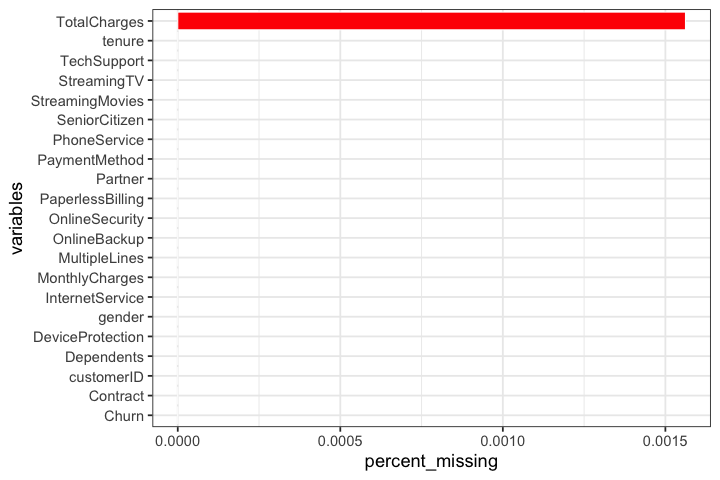

In [12]:
# Visualizing NAs in the columns

options(repr.plot.width = 6, repr.plot.height = 4)
missing_data <- telco %>% summarise_all(funs(sum(is.na(.))/n()))
missing_data <- gather(missing_data, key = "variables", value = "percent_missing")
ggplot(missing_data, aes(x = reorder(variables, percent_missing), y = percent_missing)) +
geom_bar(stat = "identity", fill = "red", aes(color = I('white')), size = 0.3)+
xlab('variables')+
coord_flip()+ 
theme_bw()

There are only 11 missing datapoints in the TotalCharges field, so getting rid of those rows from the dataset.

There are three continuous variables and they are Tenure, MonthlyCharges and TotalCharges.

SeniorCitizen is in 'int' form, that can be changed to categorical.

In [14]:
telco <- telco[complete.cases(telco),]

telco$SeniorCitizen <- as.factor(ifelse(telco$SeniorCitizen==1, 'YES', 'NO'))

EXPLORATORY DATA ANALYSIS

In [15]:
theme1 <- theme_bw()+
theme(axis.text.x = element_text(angle = 0, hjust = 1, vjust = 0.5),legend.position="none")
theme2 <- theme_bw()+
theme(axis.text.x = element_text(angle = 90, hjust = 1, vjust = 0.5),legend.position="none")

In [16]:
glimpse(telco)

Rows: 7,032
Columns: 21
$ customerID       <chr> "7590-VHVEG", "5575-GNVDE", "3668-QPYBK", "7795-CFOCW…
$ gender           <chr> "Female", "Male", "Male", "Male", "Female", "Female",…
$ SeniorCitizen    <fct> NO, NO, NO, NO, NO, NO, NO, NO, NO, NO, NO, NO, NO, N…
$ Partner          <chr> "Yes", "No", "No", "No", "No", "No", "No", "No", "Yes…
$ Dependents       <chr> "No", "No", "No", "No", "No", "No", "Yes", "No", "No"…
$ tenure           <int> 1, 34, 2, 45, 2, 8, 22, 10, 28, 62, 13, 16, 58, 49, 2…
$ PhoneService     <chr> "No", "Yes", "Yes", "No", "Yes", "Yes", "Yes", "No", …
$ MultipleLines    <chr> "No phone service", "No", "No", "No phone service", "…
$ InternetService  <chr> "DSL", "DSL", "DSL", "DSL", "Fiber optic", "Fiber opt…
$ OnlineSecurity   <chr> "No", "Yes", "Yes", "Yes", "No", "No", "No", "Yes", "…
$ OnlineBackup     <chr> "Yes", "No", "Yes", "No", "No", "No", "Yes", "No", "N…
$ DeviceProtection <chr> "No", "Yes", "No", "Yes", "No", "Yes", "No", "No", "Y…
$ TechSupport   

VISUALIZING THE CATEGORICAL DATA FIRST WITH RESPECT TO CHURN

CHURN column tells us about the number of Customers who left within the last month.
Around 26% of customers left the platform within the last month.

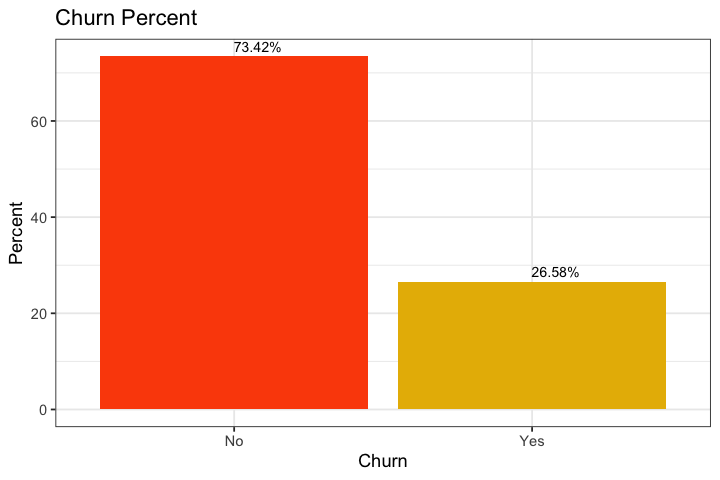

In [18]:
options(repr.plot.width = 6, repr.plot.height = 4)
telco %>% 
group_by(Churn) %>% 
summarise(Count = n())%>% 
mutate(percent = prop.table(Count)*100)%>%
ggplot(aes(reorder(Churn, -percent), percent), fill = Churn)+
geom_col(fill = c("#FC4E07", "#E7B800"))+
geom_text(aes(label = sprintf("%.2f%%", percent)), hjust = 0.01,vjust = -0.5, size =3)+ 
theme_bw()+  
xlab("Churn") + 
ylab("Percent")+
ggtitle("Churn Percent")

Gender - The churn percent is almost equal in case of Male and Females

The percent of churn is higher in case of senior citizens

Customers with Partners and Dependents have lower churn rate as compared to those who don't have partners & Dependents.

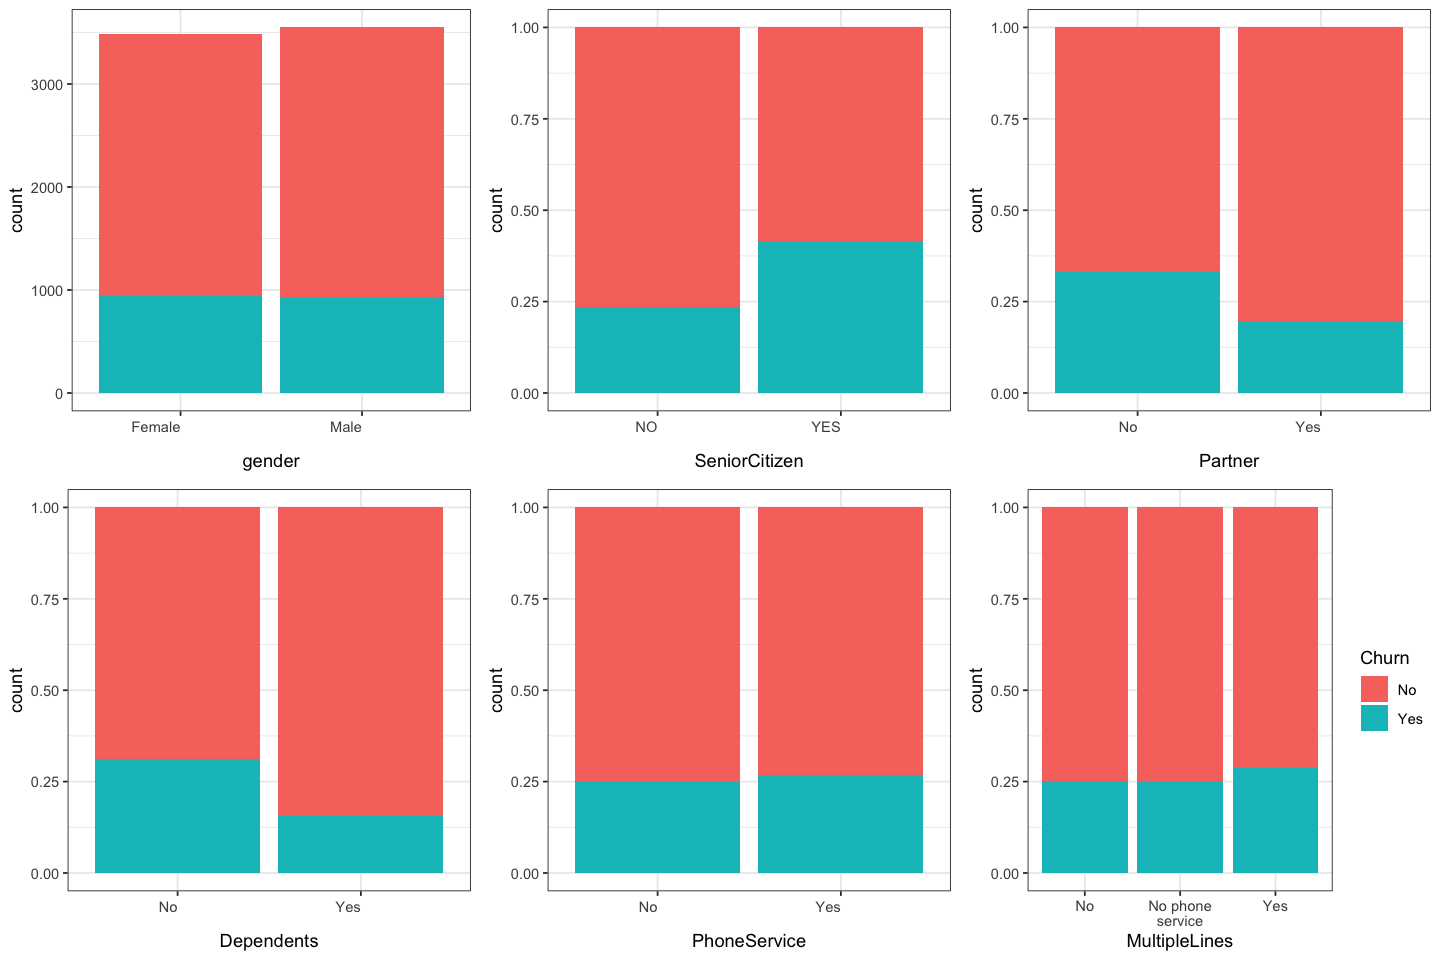

In [19]:
options(repr.plot.width = 12, repr.plot.height = 8)
plot_grid(ggplot(telco, aes(x=gender,fill=Churn))+ geom_bar()+ theme1, 
          ggplot(telco, aes(x=SeniorCitizen,fill=Churn))+ geom_bar(position = 'fill')+theme1,
          ggplot(telco, aes(x=Partner,fill=Churn))+ geom_bar(position = 'fill')+theme1,
          ggplot(telco, aes(x=Dependents,fill=Churn))+ geom_bar(position = 'fill')+theme1,
          ggplot(telco, aes(x=PhoneService,fill=Churn))+ geom_bar(position = 'fill')+theme1,
          ggplot(telco, aes(x=MultipleLines,fill=Churn))+ geom_bar(position = 'fill')+theme_bw()+
          scale_x_discrete(labels = function(x) str_wrap(x, width = 10)),
          align = "h")

Churn rate is much higher in case of Fiber Optic InternetServices.

Customers who do not have services like No OnlineSecurity , OnlineBackup and TechSupport have left the platform in the past month.

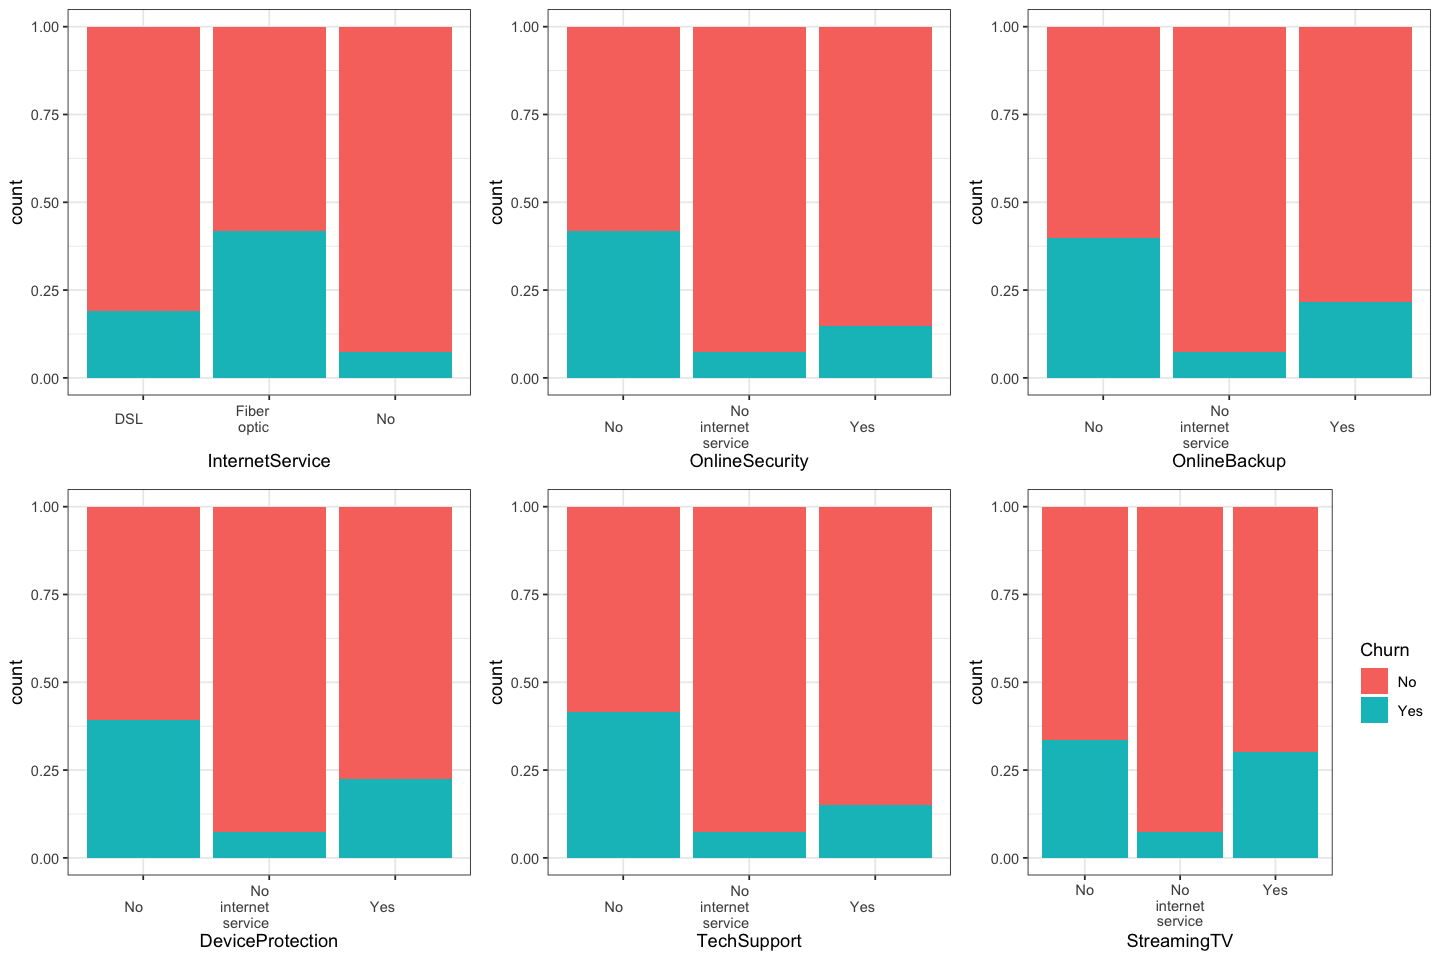

In [20]:
options(repr.plot.width = 12, repr.plot.height = 8)
plot_grid(ggplot(telco, aes(x=InternetService,fill=Churn))+ geom_bar(position = 'fill')+ theme1+
          scale_x_discrete(labels = function(x) str_wrap(x, width = 10)), 
          ggplot(telco, aes(x=OnlineSecurity,fill=Churn))+ geom_bar(position = 'fill')+theme1+
          scale_x_discrete(labels = function(x) str_wrap(x, width = 10)),
          ggplot(telco, aes(x=OnlineBackup,fill=Churn))+ geom_bar(position = 'fill')+theme1+
          scale_x_discrete(labels = function(x) str_wrap(x, width = 10)),
          ggplot(telco, aes(x=DeviceProtection,fill=Churn))+ geom_bar(position = 'fill')+theme1+
          scale_x_discrete(labels = function(x) str_wrap(x, width = 10)),
          ggplot(telco, aes(x=TechSupport,fill=Churn))+ geom_bar(position = 'fill')+theme1+
          scale_x_discrete(labels = function(x) str_wrap(x, width = 10)),
          ggplot(telco, aes(x=StreamingTV,fill=Churn))+ geom_bar(position = 'fill')+theme_bw()+
          scale_x_discrete(labels = function(x) str_wrap(x, width = 10)),
          align = "h")

A larger percent of Customers with monthly subscription have left when compared to Customers with one or two year contract.

Churn percent is higher in case of cutsomers having paperless billing option.

Customers who have ElectronicCheck PaymentMethod tend to leave the platform more when compared to other options.

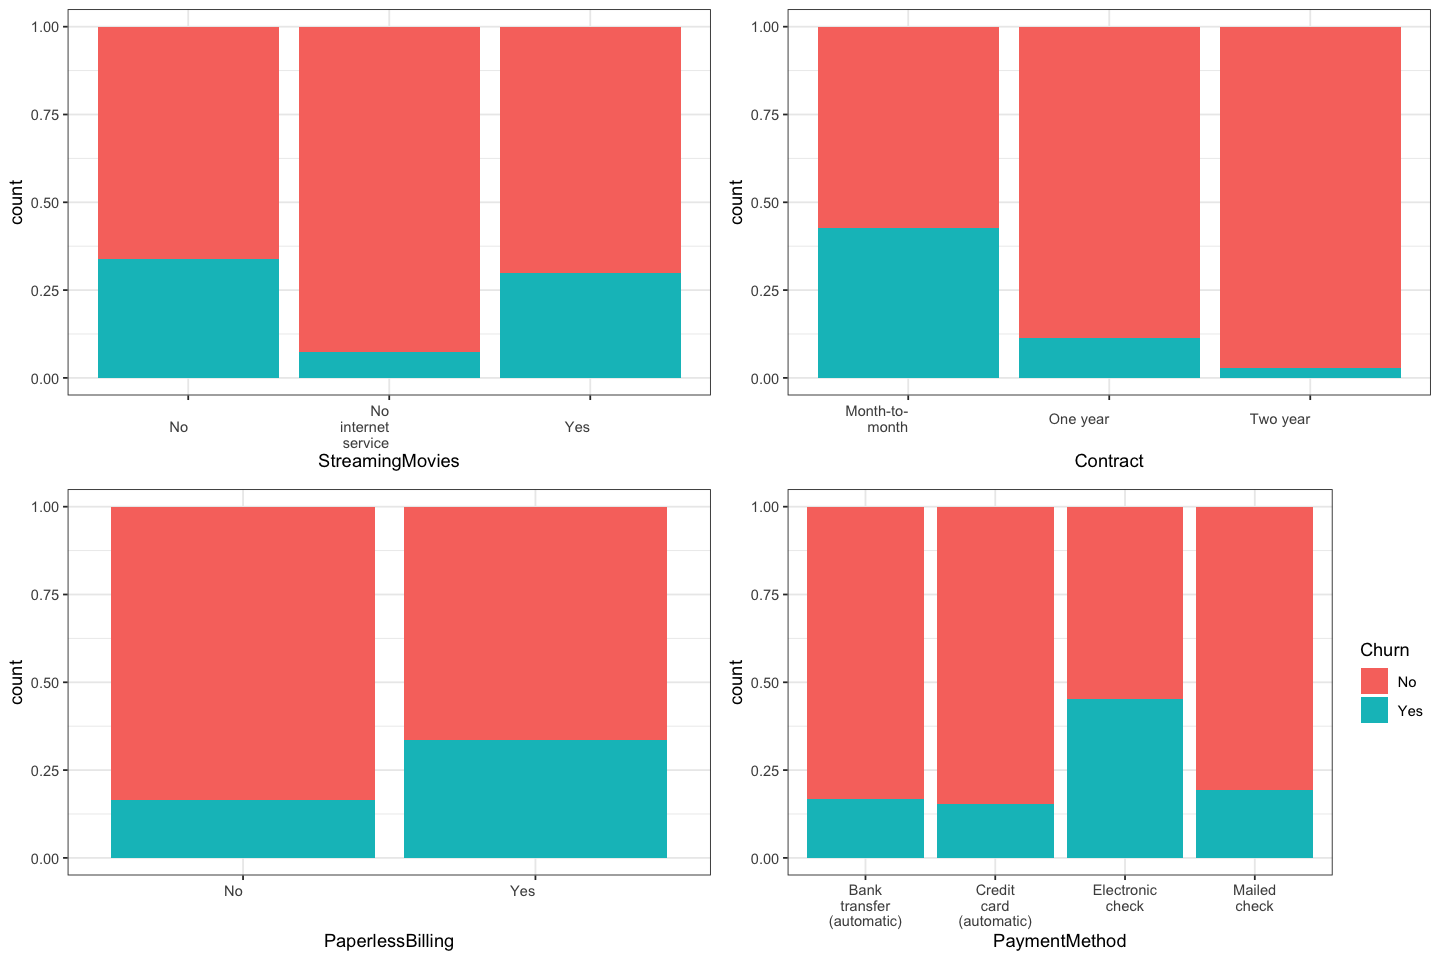

In [21]:
plot_grid(ggplot(telco, aes(x=StreamingMovies,fill=Churn))+ 
          geom_bar(position = 'fill')+ theme1+
          scale_x_discrete(labels = function(x) str_wrap(x, width = 10)), 
          ggplot(telco, aes(x=Contract,fill=Churn))+ 
          geom_bar(position = 'fill')+theme1+
          scale_x_discrete(labels = function(x) str_wrap(x, width = 10)),
          ggplot(telco, aes(x=PaperlessBilling,fill=Churn))+ 
          geom_bar(position = 'fill')+theme1+
          scale_x_discrete(labels = function(x) str_wrap(x, width = 10)),
          ggplot(telco, aes(x=PaymentMethod,fill=Churn))+
          geom_bar(position = 'fill')+theme_bw()+
          scale_x_discrete(labels = function(x) str_wrap(x, width = 10)),
          align = "h")

Analyzing the three continuous variables w.r.t CHURN

Tenure: The median tenure for customers who have left is around 10 months.

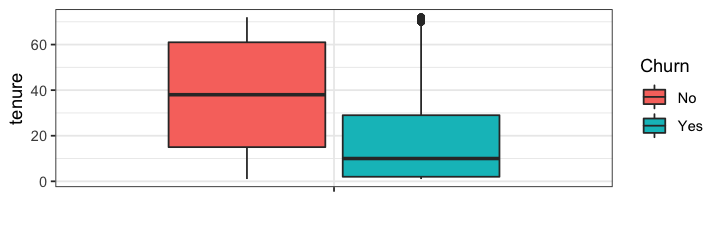

In [22]:
options(repr.plot.width =6, repr.plot.height = 2)
ggplot(telco, aes(y= tenure, x = "", fill = Churn)) + 
geom_boxplot()+ 
theme_bw()+
xlab(" ")

MonthlyCharges: Customers who have churned, have high monthly charges. The median is above 75.

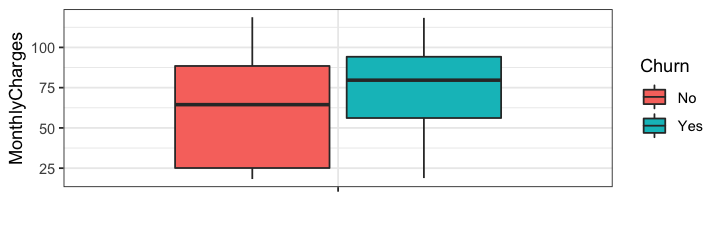

In [23]:
ggplot(telco, aes(y= MonthlyCharges, x = "", fill = Churn)) + 
geom_boxplot()+ 
theme_bw()+
xlab(" ")

TotalCharges:* The median Total charges of customers who have churned is low.

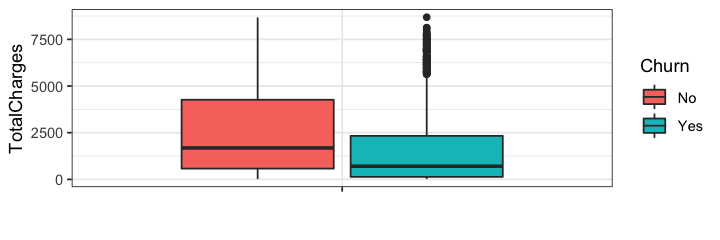

In [24]:
ggplot(telco, aes(y= TotalCharges, x = "", fill = Churn)) + 
geom_boxplot()+ 
theme_bw()+
xlab(" ")

Checking the correlation between continuous variables

Total Charges has positive correlation with MonthlyCharges and tenure.

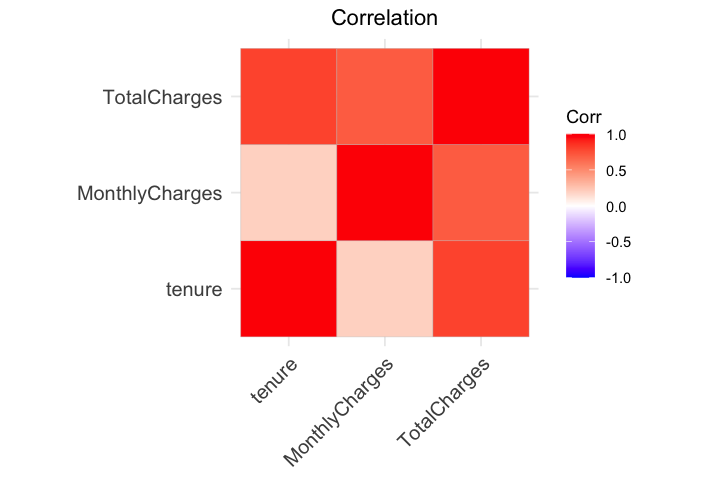

In [28]:
options(repr.plot.width =6, repr.plot.height = 4)
telco_cor <- round(cor(telco[,c("tenure", "MonthlyCharges", "TotalCharges")]), 1)

ggcorrplot(telco_cor,  title = "Correlation")+theme(plot.title = element_text(hjust = 0.5))

Checking for outliers in the continuous variables, and it seems none of the values are beyond the whiskers here.

numeric(0)

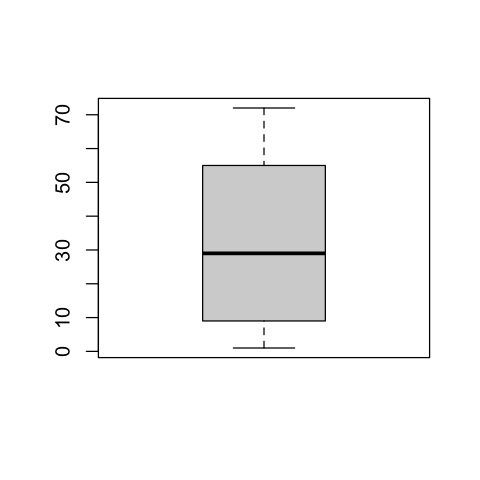

In [29]:
options(repr.plot.width =4, repr.plot.height = 4)
boxplot(telco$tenure)$out

numeric(0)

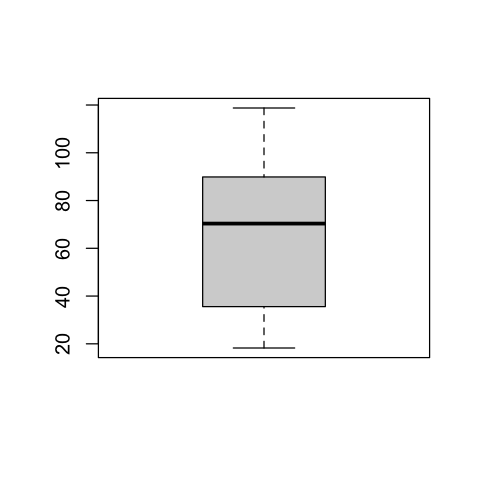

In [30]:
boxplot(telco$MonthlyCharges)$out

numeric(0)

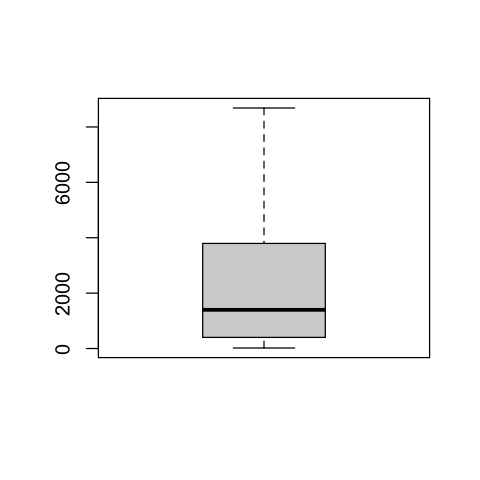

In [31]:
boxplot(telco$TotalCharges)$out

DATA PREPARATION:

Cleaning the Categorical features

Standardising Continuous features

Creating derived features

Creating dummy variables for factor variables

Creating the final dataset

Splitting the data into train and validation set

In [33]:
# Cleaning the Categorical features

# From the EDA above, we know that there are some categorical features that have 'No' and 'No Internet Service' or 'No Phone Service' as a category, we can make them as 'No' and clean these features.

telco <- data.frame(lapply(telco, function(x) {
                  gsub("No internet service", "No", x)}))

telco <- data.frame(lapply(telco, function(x) {
                  gsub("No phone service", "No", x)}))

In [34]:
# Standardising Continuous features

num_columns <- c("tenure", "MonthlyCharges", "TotalCharges")
telco[num_columns] <- sapply(telco[num_columns], as.numeric)

telco_int <- telco[,c("tenure", "MonthlyCharges", "TotalCharges")]
telco_int <- data.frame(scale(telco_int))

In [37]:
# Creating derived features

# I am trying to create a derived feature from tenure, where i have made different bins of tenure(which is in months) such as '0-1 year', '2-3 years', '3-4 years' etc.

# max(telco$tenure)
# min(telco$tenure)
telco <- mutate(telco, tenure_bin = tenure)

telco$tenure_bin[telco$tenure_bin >=0 & telco$tenure_bin <= 12] <- '0-1 year'
telco$tenure_bin[telco$tenure_bin > 12 & telco$tenure_bin <= 24] <- '1-2 years'
telco$tenure_bin[telco$tenure_bin > 24 & telco$tenure_bin <= 36] <- '2-3 years'
telco$tenure_bin[telco$tenure_bin > 36 & telco$tenure_bin <= 48] <- '3-4 years'
telco$tenure_bin[telco$tenure_bin > 48 & telco$tenure_bin <= 60] <- '4-5 years'
telco$tenure_bin[telco$tenure_bin > 60 & telco$tenure_bin <= 72] <- '5-6 years'

telco$tenure_bin <- as.factor(telco$tenure_bin)

After checking the distribution of data in each tenure bin, we find that maximum number of customers have a tenure of either 0-1 years and followed by 5-6 years.

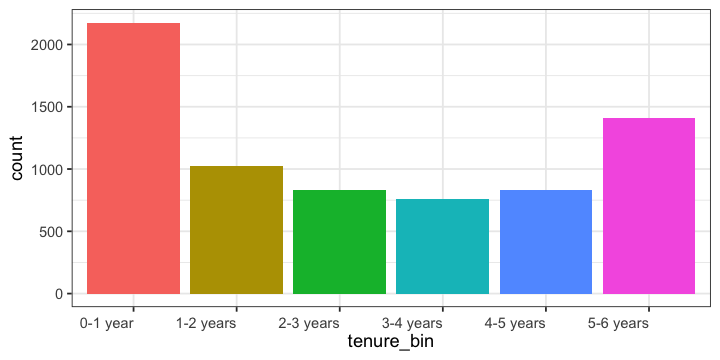

In [38]:
options(repr.plot.width =6, repr.plot.height = 3)
ggplot(telco, aes(tenure_bin, fill = tenure_bin)) + geom_bar()+ theme1

In [41]:
telco_cat <- telco[,-c(1,6,19,20)]

# Creating Dummy Variables

dummy<- data.frame(sapply(telco_cat,function(x) data.frame(model.matrix(~x-1,data =telco_cat))[,-1]))

head(dummy)

,gender,SeniorCitizen,Partner,Dependents,PhoneService,MultipleLines,InternetService.xFiber.optic,InternetService.xNo,OnlineSecurity,OnlineBackup,⋯,PaperlessBilling,PaymentMethod.xCredit.card..automatic.,PaymentMethod.xElectronic.check,PaymentMethod.xMailed.check,Churn,tenure_bin.x1.2.years,tenure_bin.x2.3.years,tenure_bin.x3.4.years,tenure_bin.x4.5.years,tenure_bin.x5.6.years
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0,0,1,0,0,0,0,0,0,1,⋯,1,0,1,0,0,0,0,0,0,0
2,1,0,0,0,1,0,0,0,1,0,⋯,0,0,0,1,0,0,1,0,0,0
3,1,0,0,0,1,0,0,0,1,1,⋯,1,0,0,1,1,0,0,0,0,0
4,1,0,0,0,0,0,0,0,1,0,⋯,0,0,0,0,0,0,0,1,0,0
5,0,0,0,0,1,0,1,0,0,0,⋯,1,0,1,0,1,0,0,0,0,0
6,0,0,0,0,1,1,1,0,0,0,⋯,1,0,1,0,1,0,0,0,0,0


In [42]:
# Creating the final dataset by combining the numeric and dummy data frames.

# Combining the data

telco_final <- cbind(telco_int,dummy)
head(telco_final)

,tenure,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,PhoneService,MultipleLines,InternetService.xFiber.optic,⋯,PaperlessBilling,PaymentMethod.xCredit.card..automatic.,PaymentMethod.xElectronic.check,PaymentMethod.xMailed.check,Churn,tenure_bin.x1.2.years,tenure_bin.x2.3.years,tenure_bin.x3.4.years,tenure_bin.x4.5.years,tenure_bin.x5.6.years
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,-1.28015700,-1.1616113,-0.9941234,0,0,1,0,0,0,0,⋯,1,0,1,0,0,0,0,0,0,0
2,0.06429811,-0.2608594,-0.1737275,1,0,0,0,1,0,0,⋯,0,0,0,1,0,0,1,0,0,0
3,-1.23941594,-0.3638974,-0.9595809,1,0,0,0,1,0,0,⋯,1,0,0,1,1,0,0,0,0,0
4,0.51244982,-0.7477972,-0.1952338,1,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,1,0,0
5,-1.23941594,0.1961642,-0.9403906,0,0,0,0,1,0,1,⋯,1,0,1,0,1,0,0,0,0,0
6,-0.99496955,1.1584066,-0.6453233,0,0,0,0,1,1,1,⋯,1,0,1,0,1,0,0,0,0,0


In [43]:
# Splitting the data into train and validation data.

set.seed(123)
indices = sample.split(telco_final$Churn, SplitRatio = 0.7)
train = telco_final[indices,]
validation = telco_final[!(indices),]

MODEL BUILDING 1

Starting with Logistic Regression

In [44]:
# Build the first model using all variables

model_1 = glm(Churn ~ ., data = train, family = "binomial")
summary(model_1)


Call:
glm(formula = Churn ~ ., family = "binomial", data = train)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.0959  -0.6765  -0.2674   0.6331   3.3919  

Coefficients:
                                        Estimate Std. Error z value Pr(>|z|)
(Intercept)                            -4.711690   1.580952  -2.980 0.002880
tenure                                 -2.419264   0.319733  -7.567 3.83e-14
MonthlyCharges                         -1.523039   1.152472  -1.322 0.186321
TotalCharges                            0.236922   0.200225   1.183 0.236699
gender                                 -0.004319   0.078799  -0.055 0.956292
SeniorCitizen                           0.342668   0.102039   3.358 0.000784
Partner                                 0.049639   0.095330   0.521 0.602570
Dependents                             -0.148501   0.110427  -1.345 0.178693
PhoneService                            0.597310   0.785026   0.761 0.446729
MultipleLines                     

Using stepAIC for variable selection, which is a iterative process of adding or removing variables, in order to get a subset of variables that gives the best performing model.

In [45]:
model_2<- stepAIC(model_1, direction="both")

Start:  AIC=4041.29
Churn ~ tenure + MonthlyCharges + TotalCharges + gender + SeniorCitizen + 
    Partner + Dependents + PhoneService + MultipleLines + InternetService.xFiber.optic + 
    InternetService.xNo + OnlineSecurity + OnlineBackup + DeviceProtection + 
    TechSupport + StreamingTV + StreamingMovies + Contract.xOne.year + 
    Contract.xTwo.year + PaperlessBilling + PaymentMethod.xCredit.card..automatic. + 
    PaymentMethod.xElectronic.check + PaymentMethod.xMailed.check + 
    tenure_bin.x1.2.years + tenure_bin.x2.3.years + tenure_bin.x3.4.years + 
    tenure_bin.x4.5.years + tenure_bin.x5.6.years

                                         Df Deviance    AIC
- gender                                  1   3983.3 4039.3
- TechSupport                             1   3983.3 4039.3
- PaymentMethod.xCredit.card..automatic.  1   3983.4 4039.4
- Partner                                 1   3983.6 4039.6
- PaymentMethod.xMailed.check             1   3983.6 4039.6
- OnlineBackup        


Step:  AIC=4033.63
Churn ~ tenure + MonthlyCharges + TotalCharges + SeniorCitizen + 
    Partner + Dependents + PhoneService + MultipleLines + InternetService.xFiber.optic + 
    InternetService.xNo + OnlineSecurity + OnlineBackup + DeviceProtection + 
    StreamingTV + StreamingMovies + Contract.xOne.year + Contract.xTwo.year + 
    PaperlessBilling + PaymentMethod.xElectronic.check + tenure_bin.x1.2.years + 
    tenure_bin.x2.3.years + tenure_bin.x3.4.years + tenure_bin.x4.5.years + 
    tenure_bin.x5.6.years

                                         Df Deviance    AIC
- Partner                                 1   3983.9 4031.9
- tenure_bin.x1.2.years                   1   3984.2 4032.2
- OnlineSecurity                          1   3984.9 4032.9
- OnlineBackup                            1   3984.9 4032.9
- TotalCharges                            1   3985.0 4033.0
- Dependents                              1   3985.5 4033.5
<none>                                        3983.6 4033.6
-


Step:  AIC=4029.04
Churn ~ tenure + MonthlyCharges + SeniorCitizen + Dependents + 
    PhoneService + MultipleLines + InternetService.xFiber.optic + 
    InternetService.xNo + OnlineSecurity + DeviceProtection + 
    StreamingTV + StreamingMovies + Contract.xOne.year + Contract.xTwo.year + 
    PaperlessBilling + PaymentMethod.xElectronic.check + tenure_bin.x2.3.years + 
    tenure_bin.x3.4.years + tenure_bin.x4.5.years + tenure_bin.x5.6.years

                                         Df Deviance    AIC
- PhoneService                            1   3988.5 4028.5
- Dependents                              1   3988.6 4028.6
<none>                                        3987.0 4029.0
+ OnlineBackup                            1   3985.8 4029.8
+ TotalCharges                            1   3985.8 4029.8
- DeviceProtection                        1   3990.0 4030.0
+ TechSupport                             1   3986.1 4030.1
+ tenure_bin.x1.2.years                   1   3986.6 4030.6
- OnlineSe


Step:  AIC=4027.28
Churn ~ tenure + MonthlyCharges + SeniorCitizen + MultipleLines + 
    InternetService.xFiber.optic + InternetService.xNo + OnlineSecurity + 
    StreamingTV + StreamingMovies + Contract.xOne.year + Contract.xTwo.year + 
    PaperlessBilling + PaymentMethod.xElectronic.check + tenure_bin.x2.3.years + 
    tenure_bin.x3.4.years + tenure_bin.x4.5.years + tenure_bin.x5.6.years + 
    TechSupport

                                         Df Deviance    AIC
<none>                                        3989.3 4027.3
- TechSupport                             1   3991.7 4027.7
+ Dependents                              1   3987.7 4027.7
+ DeviceProtection                        1   3987.8 4027.8
+ TotalCharges                            1   3987.9 4027.9
+ tenure_bin.x1.2.years                   1   3988.9 4028.9
+ PhoneService                            1   3989.1 4029.1
+ PaymentMethod.xMailed.check             1   3989.2 4029.2
+ OnlineBackup                            1

In [46]:
summary(model_2)


Call:
glm(formula = Churn ~ tenure + MonthlyCharges + SeniorCitizen + 
    MultipleLines + InternetService.xFiber.optic + InternetService.xNo + 
    OnlineSecurity + StreamingTV + StreamingMovies + Contract.xOne.year + 
    Contract.xTwo.year + PaperlessBilling + PaymentMethod.xElectronic.check + 
    tenure_bin.x2.3.years + tenure_bin.x3.4.years + tenure_bin.x4.5.years + 
    tenure_bin.x5.6.years + TechSupport, family = "binomial", 
    data = train)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.1461  -0.6661  -0.2733   0.6249   3.3018  

Coefficients:
                                Estimate Std. Error z value Pr(>|z|)    
(Intercept)                     -3.37123    0.27189 -12.399  < 2e-16 ***
tenure                          -2.07853    0.17751 -11.709  < 2e-16 ***
MonthlyCharges                  -0.52335    0.19800  -2.643 0.008213 ** 
SeniorCitizen                    0.37111    0.10031   3.700 0.000216 ***
MultipleLines                    0.38516    0.10

We can use variance inflation factor (vif) to get rid of redundant predictors or the variables that have high multicollinearity between them. Multicollinearity exists when two or more predictor variables are highly related to each other and then it becomes difficult to understand the impact of an independent variable on the dependent variable.

The Variance Inflation Factor(VIF) is used to measure the multicollinearity between predictor variables in a model. A predictor having a VIF of 2 or less is generally considered safe and it can be assumed that it is not correlated with other predictor variables. Higher the VIF, greater is the correlation of the predictor variable w.r.t other predictor variables. However, Predictors with high VIF may have high p-value(or highly significant), hence, we need to see the significance of the Predictor variable before removing it from our model.

In [47]:
vif(model_2)

tenure                  MonthlyCharges 
                      15.076710                       20.162188 
                  SeniorCitizen                   MultipleLines 
                       1.100707                        1.838876 
   InternetService.xFiber.optic             InternetService.xNo 
                       8.225529                        2.489968 
                 OnlineSecurity                     StreamingTV 
                       1.246308                        2.206225 
                StreamingMovies              Contract.xOne.year 
                       2.122071                        1.386381 
             Contract.xTwo.year                PaperlessBilling 
                       1.371229                        1.125064 
PaymentMethod.xElectronic.check           tenure_bin.x2.3.years 
                       1.149683                        2.656673 
          tenure_bin.x3.4.years           tenure_bin.x4.5.years 
                       4.106103                        6.527227 
          tenure_bin.x5.6.years                     TechSupport 
                       8.568998                        1.332821

In [48]:
# Removing DeviceProtection due to high p-value 

model_3 <-glm(formula = Churn ~ tenure + MonthlyCharges + SeniorCitizen + 
    Partner + InternetService.xFiber.optic + InternetService.xNo + 
    OnlineSecurity + OnlineBackup + TechSupport + 
    StreamingTV + Contract.xOne.year + Contract.xTwo.year + PaperlessBilling + 
    PaymentMethod.xElectronic.check + tenure_bin.x1.2.years + 
    tenure_bin.x5.6.years, family = "binomial", data = train)
summary(model_3)
vif(model_3)


Call:
glm(formula = Churn ~ tenure + MonthlyCharges + SeniorCitizen + 
    Partner + InternetService.xFiber.optic + InternetService.xNo + 
    OnlineSecurity + OnlineBackup + TechSupport + StreamingTV + 
    Contract.xOne.year + Contract.xTwo.year + PaperlessBilling + 
    PaymentMethod.xElectronic.check + tenure_bin.x1.2.years + 
    tenure_bin.x5.6.years, family = "binomial", data = train)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.9863  -0.6589  -0.2775   0.6424   3.2758  

Coefficients:
                                Estimate Std. Error z value Pr(>|z|)    
(Intercept)                     -1.48117    0.17354  -8.535  < 2e-16 ***
tenure                          -0.88438    0.07316 -12.088  < 2e-16 ***
MonthlyCharges                   0.08404    0.15461   0.544 0.586731    
SeniorCitizen                    0.37893    0.09935   3.814 0.000137 ***
Partner                         -0.02734    0.08496  -0.322 0.747590    
InternetService.xFiber.optic     0.73

tenure                  MonthlyCharges 
                       2.540970                       12.310900 
                  SeniorCitizen                         Partner 
                       1.092995                        1.133093 
   InternetService.xFiber.optic             InternetService.xNo 
                       6.398204                        2.142763 
                 OnlineSecurity                    OnlineBackup 
                       1.180975                        1.288093 
                    TechSupport                     StreamingTV 
                       1.271133                        2.122655 
             Contract.xOne.year              Contract.xTwo.year 
                       1.360444                        1.392469 
               PaperlessBilling PaymentMethod.xElectronic.check 
                       1.120396                        1.141949 
          tenure_bin.x1.2.years           tenure_bin.x5.6.years 
                       1.028052                        1.757701

In [49]:
# Removing StreamingTV  as it has high p-value 

model_4 <- glm(formula = Churn ~ tenure + MonthlyCharges + SeniorCitizen + 
    Partner + InternetService.xFiber.optic + InternetService.xNo + 
    OnlineSecurity + OnlineBackup + TechSupport +  
    Contract.xOne.year + Contract.xTwo.year + PaperlessBilling + 
    PaymentMethod.xElectronic.check + tenure_bin.x1.2.years + 
    tenure_bin.x5.6.years, family = "binomial", data = train)

summary(model_4)
vif(model_4)


Call:
glm(formula = Churn ~ tenure + MonthlyCharges + SeniorCitizen + 
    Partner + InternetService.xFiber.optic + InternetService.xNo + 
    OnlineSecurity + OnlineBackup + TechSupport + Contract.xOne.year + 
    Contract.xTwo.year + PaperlessBilling + PaymentMethod.xElectronic.check + 
    tenure_bin.x1.2.years + tenure_bin.x5.6.years, family = "binomial", 
    data = train)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.9552  -0.6643  -0.2791   0.6644   3.2717  

Coefficients:
                                Estimate Std. Error z value Pr(>|z|)    
(Intercept)                     -1.24627    0.15025  -8.295  < 2e-16 ***
tenure                          -0.87338    0.07296 -11.970  < 2e-16 ***
MonthlyCharges                   0.35114    0.12173   2.885 0.003918 ** 
SeniorCitizen                    0.37827    0.09923   3.812 0.000138 ***
Partner                         -0.02668    0.08487  -0.314 0.753275    
InternetService.xFiber.optic     0.45825    0.17270

tenure                  MonthlyCharges 
                       2.528728                        7.598828 
                  SeniorCitizen                         Partner 
                       1.092734                        1.133297 
   InternetService.xFiber.optic             InternetService.xNo 
                       4.776780                        1.985836 
                 OnlineSecurity                    OnlineBackup 
                       1.143833                        1.258626 
                    TechSupport              Contract.xOne.year 
                       1.252283                        1.358085 
             Contract.xTwo.year                PaperlessBilling 
                       1.390401                        1.114992 
PaymentMethod.xElectronic.check           tenure_bin.x1.2.years 
                       1.131205                        1.027896 
          tenure_bin.x5.6.years 
                       1.752778

In [50]:
# Model_3 all has significant variables, so let's just use it for prediction first

final_model <- model_3

In [51]:
# Model Evaluation using the validation data

pred <- predict(final_model, type = "response", newdata = validation[,-24])
summary(pred)
validation$prob <- pred

# Using probability cutoff of 50%.

pred_churn <- factor(ifelse(pred >= 0.50, "Yes", "No"))
actual_churn <- factor(ifelse(validation$Churn==1,"Yes","No"))
table(actual_churn,pred_churn)

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
0.004518 0.041437 0.186763 0.268617 0.470467 0.868907 

            pred_churn
actual_churn   No  Yes
         No  1382  167
         Yes  275  286

Let's find the Accuracy, Sensitivity, Specificity using 50% cutoff

In [52]:
perform_fn <- function(cutoff) 
{
  predicted_churn <- factor(ifelse(pred >= cutoff, "Yes", "No"))
  conf <- confusionMatrix(predicted_churn, actual_churn, positive = "Yes")
  accuray <- conf$overall[1]
  sensitivity <- conf$byClass[1]
  specificity <- conf$byClass[2]
  out <- t(as.matrix(c(sensitivity, specificity, accuray))) 
  colnames(out) <- c("sensitivity", "specificity", "accuracy")
  return(out)
}

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
0.004518 0.041437 0.186763 0.268617 0.470467 0.868907 

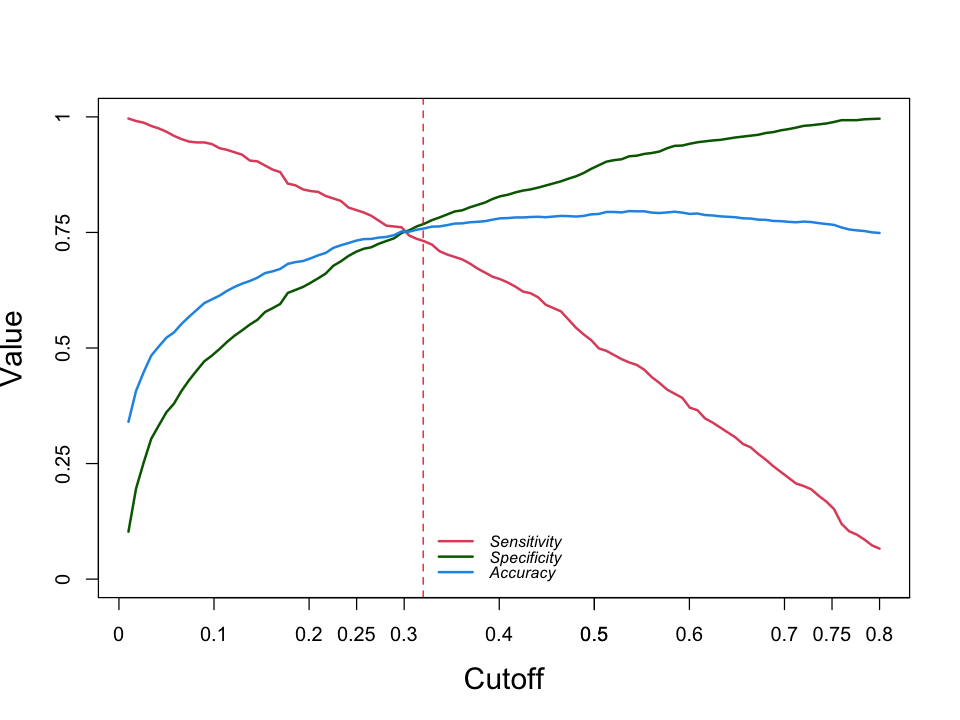

In [53]:
options(repr.plot.width =8, repr.plot.height =6)
summary(pred)
s = seq(0.01,0.80,length=100)
OUT = matrix(0,100,3)

for(i in 1:100)
{
  OUT[i,] = perform_fn(s[i])
} 

plot(s, OUT[,1],xlab="Cutoff",ylab="Value",cex.lab=1.5,cex.axis=1.5,ylim=c(0,1),
     type="l",lwd=2,axes=FALSE,col=2)
axis(1,seq(0,1,length=5),seq(0,1,length=5),cex.lab=1.5)
axis(2,seq(0,1,length=5),seq(0,1,length=5),cex.lab=1.5)
lines(s,OUT[,2],col="darkgreen",lwd=2)
lines(s,OUT[,3],col=4,lwd=2)
box()
legend("bottom",col=c(2,"darkgreen",4,"darkred"),text.font =3,inset = 0.02,
       box.lty=0,cex = 0.8, 
       lwd=c(2,2,2,2),c("Sensitivity","Specificity","Accuracy"))
abline(v = 0.32, col="red", lwd=1, lty=2)
axis(1, at = seq(0.1, 1, by = 0.1))

# cutoff <- s[which(abs(OUT[,1]-OUT[,2])<0.01)]

Let's choose a cutoff value of 0.32 for final model, where the three curves for accuracy, specificty and sensitivity meet

In [54]:
cutoff_churn <- factor(ifelse(pred >=0.32, "Yes", "No"))
conf_final <- confusionMatrix(cutoff_churn, actual_churn, positive = "Yes")
accuracy <- conf_final$overall[1]
sensitivity <- conf_final$byClass[1]
specificity <- conf_final$byClass[2]
accuracy
sensitivity
specificity

Accuracy 
0.7582938

Sensitivity 
  0.7308378

Specificity 
  0.7682376

Logistic Regression with a cutoff probability value of 0.32 gives us better values of accuracy, sensitivity and specificity in the validation data.

Setting levels: control = 0, case = 1

Setting direction: controls < cases



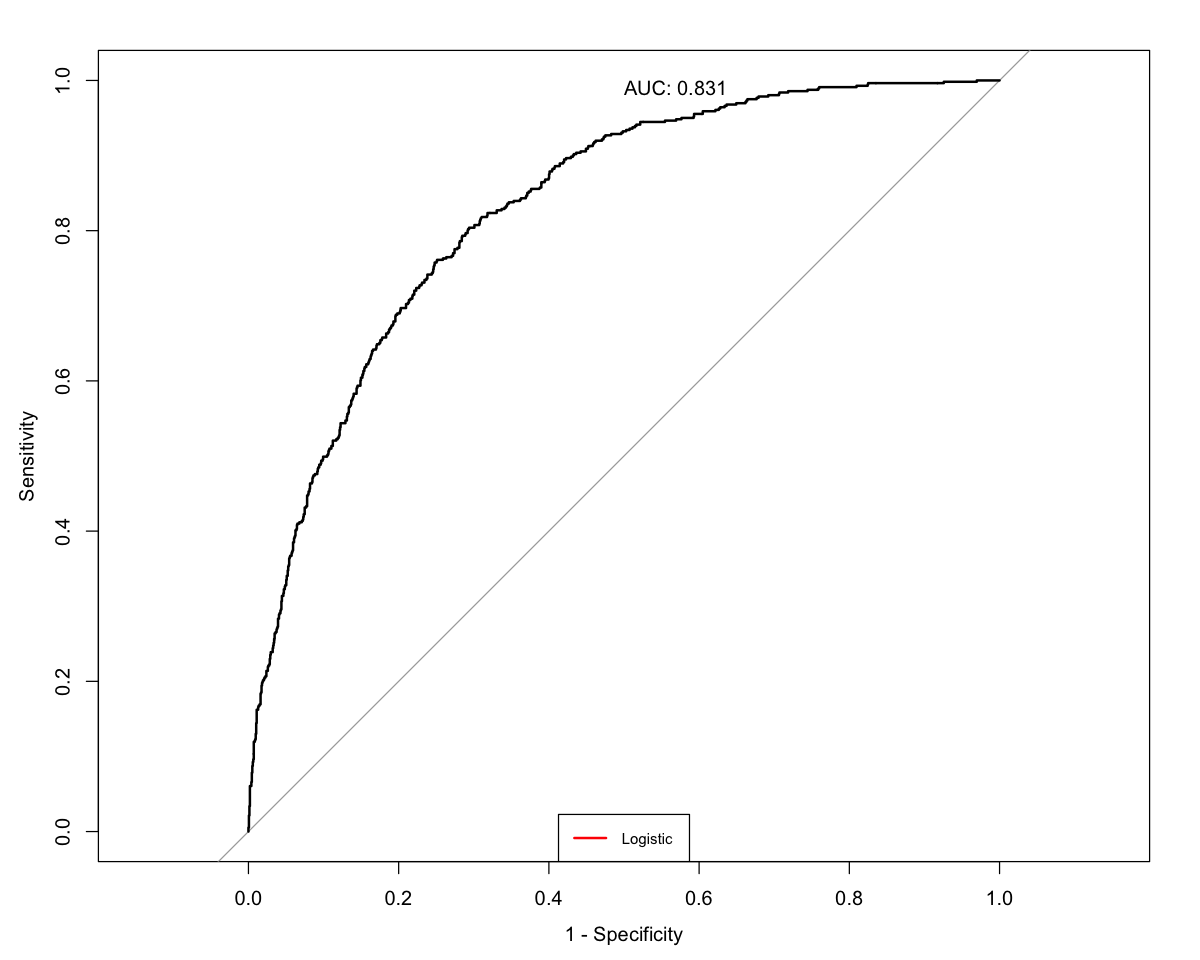

In [55]:
options(repr.plot.width =10, repr.plot.height = 8)

glm.roc <- roc(response = validation$Churn, predictor = as.numeric(pred))

plot(glm.roc,legacy.axes = TRUE, print.auc.y = 1.0, print.auc = TRUE)

legend("bottom", c("Logistic"),
       lty = c(1,1), lwd = c(2, 2), col = c("red"), cex = 0.75)